In [1]:
import pong

import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
SEQ_LEN = 88
W, H = 50, 50

def make_batcher(bs):
    next_batch = pong.parallel_batch_generator(
        bs=16,
        W=W,
        H=H,
        seq_len=SEQ_LEN,
        max_iter=1000000000,
        num_workers=1,
    )

    while True:
        directions, controls, frames, game_over = next(next_batch)
        yield [directions, controls], [frames, game_over]

In [5]:
next_batch = make_batcher(bs=16)

X, Y = next(next_batch)

[directions, controls], [frames, game_over] = X, Y
directions.shape, controls.shape, frames.shape, game_over.shape

((16,), (16, 88, 2), (16, 88, 50, 50), (16, 88))

In [6]:
def mk_model():
    direction_inp = tf.keras.layers.Input(shape=(1), name='dir_input')
    user_input = tf.keras.layers.Input(shape=(SEQ_LEN, 2), name='user_input')

    hidden_direction = tf.keras.layers.Dense(
        100,
        name='hidden_dir_input',
    )(direction_inp)

    activation_direction = tf.keras.layers.Dense(
        100,
        name='activation_dir_input',
    )(direction_inp)
    
    transformed_user_input = tf.keras.layers.LSTM(
        100,
        return_sequences=True,
        name='transformed_user_inpuit'
    )(user_input)

    x = tf.keras.layers.LSTM(
        100,
        return_sequences=True,
        name='x'
    )(
        transformed_user_input,
        initial_state=[activation_direction, hidden_direction]
    )

    frames = tf.keras.layers.Dense(W * H)(x)
    frames = tf.reshape(frames, (-1, SEQ_LEN, W, H), name='frames')
    
    game_over = tf.keras.layers.Dense(1)(x)
    game_over = tf.squeeze(game_over, [-1], name='game_over')

    model = tf.keras.Model([direction_inp, user_input], [frames, game_over])
    
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    return model

In [15]:
model = mk_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 88, 2)]      0                                            
__________________________________________________________________________________________________
dir_input (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
transformed_user_inpuit (LSTM)  (None, 88, 100)      41200       user_input[0][0]                 
__________________________________________________________________________________________________
activation_dir_input (Dense)    (None, 100)          200         dir_input[0][0]                  
____________________________________________________________________________________________

In [16]:
output = model.predict([directions, controls])

output[0].shape, output[1].shape

((16, 88, 50, 50), (16, 88))

In [18]:
input_generator = make_batcher(bs=64)

model.fit_generator(
    generator=input_generator,
    validation_data=input_generator,

    validation_steps=25,
    steps_per_epoch=50,
    epochs=5
)

Epoch 1/5
50/50 [==============================] - 13s 252ms/step - loss: 0.3923 - tf_op_layer_frames_1_loss: 0.3861 - tf_op_layer_game_over_1_loss: 0.0062 - tf_op_layer_frames_1_acc: 0.9124 - tf_op_layer_game_over_1_acc: 0.9997 - val_loss: 0.2259 - val_tf_op_layer_frames_1_loss: 0.2176 - val_tf_op_layer_game_over_1_loss: 0.0083 - val_tf_op_layer_frames_1_acc: 0.9213 - val_tf_op_layer_game_over_1_acc: 0.9995
Epoch 2/5
50/50 [==============================] - 10s 210ms/step - loss: 0.2061 - tf_op_layer_frames_1_loss: 0.2004 - tf_op_layer_game_over_1_loss: 0.0057 - tf_op_layer_frames_1_acc: 0.9267 - tf_op_layer_game_over_1_acc: 0.9996 - val_loss: 0.1959 - val_tf_op_layer_frames_1_loss: 0.1884 - val_tf_op_layer_game_over_1_loss: 0.0074 - val_tf_op_layer_frames_1_acc: 0.9310 - val_tf_op_layer_game_over_1_acc: 0.9995
Epoch 3/5
50/50 [==============================] - 11s 210ms/step - loss: 0.1809 - tf_op_layer_frames_1_loss: 0.1754 - tf_op_layer_game_over_1_loss: 0.0055 - tf_op_layer_frames

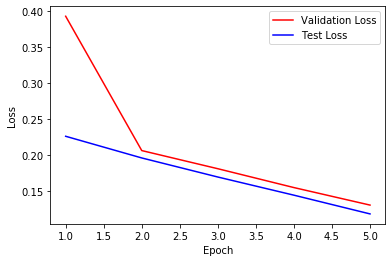

In [22]:
training_loss = model.history.history['loss']
test_loss = model.history.history['val_loss']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r')
plt.plot(epoch_count, test_loss, 'b')
plt.legend(['Validation Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();